In [4]:
!pip install transformers

In [5]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import transformers
from transformers import AutoModel, DistilBertTokenizer
import matplotlib.pyplot as plt

# specify GPU
device = torch.device("cuda")

In [6]:
df = pd.read_excel("Final opinie.xlsx")
df.head(10)

,Opinia,Klasa
0,Nie użyłbym ponownie. Brak organizacji i brak ...,Very Negative
1,"Przykro mi, ale nie mogę zostawić komentarza, ...",Neutral
2,"Nie uczyłem się do ogólnego egzaminu A-level, ...",Negative
3,Nie było to zbyt profesjonalne. Pojawiłem się ...,Negative
4,Dobry,Neutral
5,Niestety nie mogę zatrudnić pani Bei do korepe...,Negative
6,"Clare była urocza, jednak była sucha i czytała...",Neutral
7,"Korepetytorka nie jest punktualna i rzetelna, ...",Negative
8,Ogólnie całkiem nieźle,Neutral
9,Lekcje nie są prywatne. Jednak na egzaminie wy...,Neutral


In [7]:
df.shape

(1100, 2)

In [8]:
#Przed mapowaniem
df['Klasa'].value_counts(normalize = True)

,proportion
Klasa,
Very Negative,0.2
Neutral,0.2
Negative,0.2
Positive,0.2
Very Positive,0.2


In [9]:
#Mapowanie
sentiment_mapping = {
    "Very Negative": 0,
    "Negative": 1,
    "Neutral": 2,
    "Positive": 3,
    "Very Positive": 4
}

df['label'] = df['Klasa'].map(sentiment_mapping)
#Po mapowaniu
df['label'].value_counts(normalize = True)

,proportion
label,
0,0.2
2,0.2
1,0.2
3,0.2
4,0.2


In [10]:
train_text, temp_text, train_labels, temp_labels = train_test_split(df['Opinia'], df['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=df['label'])

# we will use temp_text and temp_labels to create validation and test set
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)
print("Liczba próbek w zbiorach:")
print(f"Train: {len(train_text)}, Validation: {len(val_text)}, Test: {len(test_text)}")



Liczba próbek w zbiorach:
Train: 770, Validation: 165, Test: 165


In [11]:
# import BERT-base pretrained model
tabu = AutoModel.from_pretrained("tabularisai/multilingual-sentiment-analysis")

# Load the BERT tokenizer
tokenizer = DistilBertTokenizer.from_pretrained("tabularisai/multilingual-sentiment-analysis")


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/902 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.92M [00:00<?, ?B/s]

In [12]:
# sample data
text = ["this is a bert model tutorial", "we will fine-tune a bert model"]

# encode text
sent_id = tokenizer.batch_encode_plus(text, padding=True, return_token_type_ids=False)

In [13]:
# output
print(sent_id)

{'input_ids': [[101, 10531, 10124, 169, 10347, 10976, 13192, 69635, 34108, 102, 0], [101, 11951, 11337, 13435, 118, 91695, 169, 10347, 10976, 13192, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


<Axes: >

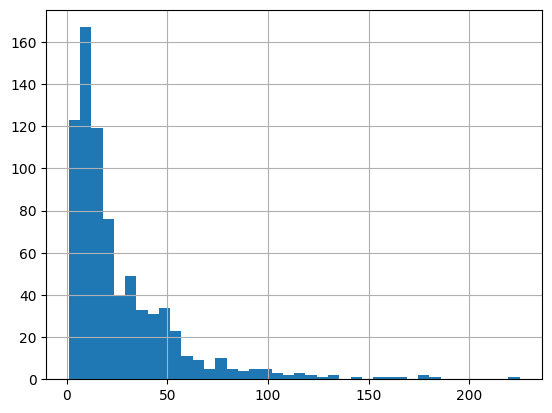

In [14]:
#Tokenization, replacing number sequences with tensors

#length of messages in train data
seq_len = [len(i.split()) for i in train_text]

pd.Series(seq_len).hist(bins = 40)

In [15]:
#as we can see most of the messages are shorter than 50 words, we will set the maximum length to 50

max_seq_len = 50

In [16]:
#tokenize and encode sequences in the training set, validation set and test set
tokens_train = tokenizer.batch_encode_plus(train_text.tolist(), max_length = max_seq_len, padding='max_length', truncation=True, return_token_type_ids=False)

tokens_val = tokenizer.batch_encode_plus(val_text.tolist(), max_length = max_seq_len, padding='max_length', truncation=True, return_token_type_ids=False)

tokens_test = tokenizer.batch_encode_plus(test_text.tolist(), max_length = max_seq_len, padding='max_length',truncation=True, return_token_type_ids=False)

In [17]:
# Convert Integer Sequences to Tensors for train set, validation set and test set
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [18]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#define a batch size
batch_size = 32

# wrap tensors
train_data = TensorDataset(train_seq, train_mask, train_y)

# sampler for sampling the data during training
train_sampler = RandomSampler(train_data)

# dataLoader for train set
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# wrap tensors
val_data = TensorDataset(val_seq, val_mask, val_y)

# sampler for sampling the data during training
val_sampler = SequentialSampler(val_data)

# dataLoader for validation set
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)

In [19]:
# freeze all the parameters
for param in tabu.parameters():
    param.requires_grad = False

In [20]:
# class for tabularisai model

class Tabu_Architecture(nn.Module):

    def __init__(self, tabu):

      super(Tabu_Architecture, self).__init__()

      self.tabu = tabu

      # dropout layer
      self.dropout = nn.Dropout(0.1)

      # relu activation function
      self.relu =  nn.ReLU()

      # dense layer 1
      self.fc1 = nn.Linear(768,512)

      # dense layer 2 (Output layer)
      self.fc2 = nn.Linear(512,2)

      #softmax activation function
      self.softmax = nn.LogSoftmax(dim=1)

    #define the forward pass
    def forward(self, sent_id, mask):

      #pass the inputs to the model
      _, cls_hs = self.tabu(sent_id, attention_mask=mask)

      x = self.fc1(cls_hs)

      x = self.relu(x)

      x = self.dropout(x)

      # output layer
      x = self.fc2(x)

      # apply softmax activation
      x = self.softmax(x)

      return x

# pass the pre-trained tabularisiai model to our define architecture
model = Tabu_Architecture(tabu)

# push the model to GPU
model = model.to(device)

In [21]:
from torch.optim import AdamW

# Define the optimizer
optimizer = AdamW(model.parameters(), lr=1e-3)

In [22]:
from sklearn.utils.class_weight import compute_class_weight

# loss function
cross_entropy  = nn.NLLLoss()

# number of training epochs
epochs = 10